# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [9]:
# Подключаем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats as st
# Время обучения модели
import timeit
import lightgbm

# Разбиение на обучающую, валидационную и тестовую выборку
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
# Применим кроссвалидацию для повышения качеств обучения
# Для константной модели
from sklearn.dummy import DummyRegressor

# Масштабируемость модели
from sklearn.preprocessing import StandardScaler, OrdinalEncoder 

# и для машинного обучения разными способами (по условию мы выбираем линейную регрессию):
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import (
    # Точность модели
    accuracy_score,
    # Матрицы ошибок (для борьбы с дисбалансом)
    confusion_matrix, 
    # Полнота
    recall_score, 
    # Точность
    precision_score, 
    # F1-мера
    f1_score,
    # Метрика AUC-ROC
    roc_auc_score,
    roc_curve,
    # MSE
    mean_squared_error,
    mean_absolute_error,
    fbeta_score, 
    make_scorer
)

# Контроль выборки
from sklearn.utils import shuffle

### Загрузим данные

In [14]:
# Получаем датасет
try:
    # С локального файла
    try:
        df = pd.read_csv('autos.csv')
    except:
        df = pd.read_csv('/datasets/autos.csv')
except:
    print('Отсутствует датасет. Проверьте путь файла')

Отсутствует датасет. Проверьте путь файла


### Изучим данные

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Дополнительные информация:**

**Признаки**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

In [7]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Тут можно заметить странное, что в колонке "год регистрации автомобиля" есть 1000 и 9999. Скорее всего это аномальное значения. Также в данный момент не существуют машин, у которых мощностей двигателя больше 143 л.с. А также странно получилось, что машина выставлена в продажах бесплатно. Ну, может быть они хотят быстрее избавиться от них, а может "ради прикола" выставили в продажах, но все равно устраняем их

Text(0, 0.5, 'Стоимость ЕВРО')

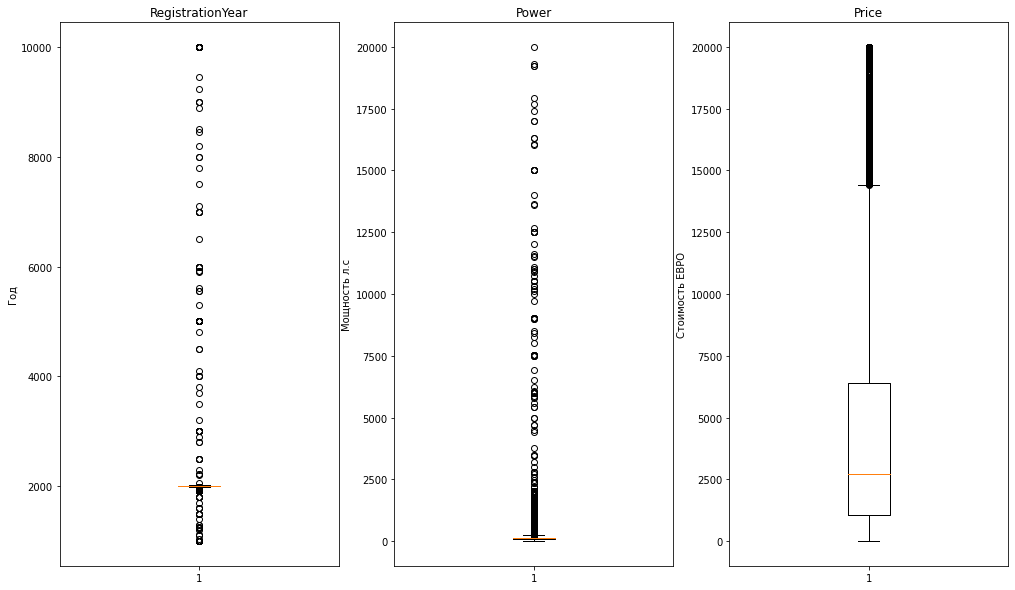

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(17, 10))

axs[0].boxplot(df['RegistrationYear'])
axs[0].set_title('RegistrationYear')
axs[0].set_ylabel('Год')
        
axs[1].boxplot(df['Power'])
axs[1].set_title('Power')
axs[1].set_ylabel('Мощность л.с')

axs[2].boxplot(df['Price'])
axs[2].set_title('Price')
axs[2].set_ylabel('Стоимость ЕВРО')

### Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, то удалим их.

Удаляем аномальные значения

In [10]:
# Очистим
# Год регистрации автомобиля
df_clean = df[df['RegistrationYear'] > (df.describe()['RegistrationYear']['50%'] - df.describe()['RegistrationYear']['std'])]
df_clean = df_clean[df_clean['RegistrationYear'] < 2023]

In [11]:
# Мощность двигателя л.с
df_clean = df_clean[df_clean['Power'] > abs(df_clean.describe()['Power']['50%'] - df_clean.describe()['Power']['std'])]
df_clean = df_clean[df_clean['Power'] < abs(df_clean.describe()['Power']['75%'] + df_clean.describe()['Power']['std'])]

In [12]:
# Бесплатные автомобили и слишком дешевые автомобили
df_clean = df_clean[df_clean['Price'] > abs(df_clean.describe()['Price']['50%'] - df_clean.describe()['Price']['std'])]

In [13]:
df_clean.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,202868.000000,202868.000000,202868.000000,202868.000000,202868.000000,202868.0,202868.000000
mean,6243.655318,2004.211334,143.444417,129597.447601,6.121646,0.0,52105.827829
std,4797.468519,6.343907,46.619757,35773.573448,3.540755,0.0,25906.456594
min,780.000000,1937.000000,85.000000,5000.000000,0.000000,0.0,1067.000000
25%,2399.000000,2000.000000,109.000000,125000.000000,3.000000,0.0,31552.000000
50%,4800.000000,2005.000000,136.000000,150000.000000,6.000000,0.0,51429.000000
75%,8990.000000,2008.000000,165.000000,150000.000000,9.000000,0.0,73066.000000
max,20000.000000,2019.000000,390.000000,150000.000000,12.000000,0.0,99998.000000


Text(0, 0.5, 'Стоимость ЕВРО')

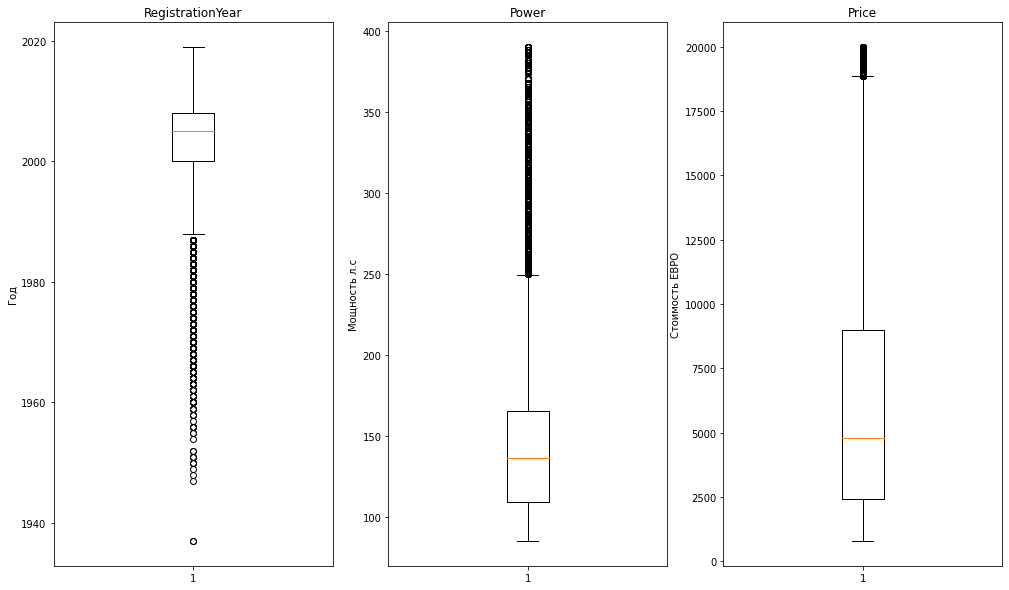

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(17, 10))

axs[0].boxplot(df_clean['RegistrationYear'])
axs[0].set_title('RegistrationYear')
axs[0].set_ylabel('Год')
        
axs[1].boxplot(df_clean['Power'])
axs[1].set_title('Power')
axs[1].set_ylabel('Мощность л.с')

axs[2].boxplot(df_clean['Price'])
axs[2].set_title('Price')
axs[2].set_ylabel('Стоимость ЕВРО')

Устранили аномальные значения, теперь смотрим кол-во пропущенных значений

In [15]:
df_clean.isna().sum()

DateCrawled              0
Price                    0
VehicleType          11090
RegistrationYear         0
Gearbox               2555
Power                    0
Model                 7150
Kilometer                0
RegistrationMonth        0
FuelType             10338
Brand                    0
Repaired             25729
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [16]:
len(df_clean)

202868

Тип автомобилей, коробки передачи, модели, топлива и состояния ремонта мы не можем поставить усредненные значения, т.к. это является уникальными. Но у нас достаточно информаций, чтобы можно устранять эти нежелательные пропуски

In [17]:
# Устраняем
df_clean = df_clean[~df_clean['VehicleType'].isna()]
df_clean = df_clean[~df_clean['Gearbox'].isna()]
df_clean = df_clean[~df_clean['Model'].isna()]
df_clean = df_clean[~df_clean['FuelType'].isna()]
df_clean = df_clean[~df_clean['Repaired'].isna()]

In [18]:
# Проверим
df_clean.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [19]:
# Сбрасываем и снова пронумерируем индексы
df_clean = df_clean.reset_index(drop=True)

In [20]:
# Преобразуем на другой тип данных DateCrawled, DateCreated и LastSeen
df_clean['DateCrawled'] = pd.to_datetime(df_clean['DateCrawled'])
df_clean['DateCreated'] = pd.to_datetime(df_clean['DateCreated'])
df_clean['LastSeen'] = pd.to_datetime(df_clean['LastSeen'])

In [21]:
df_clean.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
1,2016-03-26 19:54:18,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,2016-03-26,0,96224,2016-04-06 10:45:34
2,2016-04-07 10:06:22,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes,2016-04-07,0,57290,2016-04-07 10:25:17
3,2016-03-21 12:57:01,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no,2016-03-21,0,4177,2016-04-06 07:45:42
4,2016-03-23 15:48:05,7550,bus,2007,manual,136,c_max,150000,6,gasoline,ford,no,2016-03-23,0,88361,2016-04-05 18:45:11


Теперь с данными в порядке, можно уже приступать к обучению моделей

## Обучение моделей

Перед обучением нужно сделать следующие: прямое кодирование, порядкое кодирование и масштабируемость модели. Поэтому обучение моделей будет разделен на 3 этапа: OH, OHE, SCALER

Поскольку у нас присутствуют некоторые признаки, которые являются строковыми или ojbect типами, а для машинного обучения регрессионного типа требует числа. Поэтому примением кодировку, которая будет преобразовать в числа

In [22]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162507 entries, 0 to 162506
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        162507 non-null  datetime64[ns]
 1   Price              162507 non-null  int64         
 2   VehicleType        162507 non-null  object        
 3   RegistrationYear   162507 non-null  int64         
 4   Gearbox            162507 non-null  object        
 5   Power              162507 non-null  int64         
 6   Model              162507 non-null  object        
 7   Kilometer          162507 non-null  int64         
 8   RegistrationMonth  162507 non-null  int64         
 9   FuelType           162507 non-null  object        
 10  Brand              162507 non-null  object        
 11  Repaired           162507 non-null  object        
 12  DateCreated        162507 non-null  datetime64[ns]
 13  NumberOfPictures   162507 non-null  int64   

Как и видим, что существуют несколько признаков, имеющих типа object. Теперь создадим список, который автоматически заполняет определенный тип

In [23]:
# Здесь будем сохранить результаты машинного обучения
results = pd.DataFrame()

### Прямое кодирование - One-Hot Encoding

In [24]:
# Убираем лишние признаки перед прямым кодированием
df_ohe = df[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired']]

In [25]:
# Уклоняемся от дамми-ловушек
df_ohe = pd.get_dummies(df_ohe, drop_first=True)

In [26]:
df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
0,480,1993,0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,18300,2011,190,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,7,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


#### Деление на обучающей и валидационной выборки

In [27]:
# Получаем признак и цель 
features = df_ohe.drop('Price', axis=1)
target = df_ohe['Price']

In [28]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

#### LinearRegression

In [39]:
# Функция метрика качества - sMAPE
def RMSE(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    
    distance = predict - actual

    square_distance = distance ** 2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score

In [40]:
# Подбор параметров модели с помощью make_scorer из sklearn.metrics
rmse_score = make_scorer(RMSE, greater_is_better=False)

In [43]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 5, scoring = rmse_score)

In [ ]:
%%time
# Обучаем модель с целевым признаком rougher.output.recovery
print('='*127)
print('sMAPE:')

model.fit(features, target)

sMAPE:


In [ ]:
result_RMSE = model.best_score_

In [ ]:
# Узнаем sMAPE
print('-'*127)
if (model.best_score_ < 0):
    print(':', -model.best_score_)
else:
    print(':', model.best_score_)

print('='*127)

Попробуем выявлять предсказания и RMSE методом LinearRegression

In [268]:
%%time
start_time = timeit.default_timer()

# Применяем метод линейной регрессии
model = LinearRegression()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train) 

# Получим предсказания модели на валидационной выборке
predictions_valid = model.predict(features_valid) 

# Посчитаем значение метрики RMSE на валидационной выборке
result_RMSE = mean_squared_error(target_valid, predictions_valid) ** 0.5

print('RMSE модели линейной регрессии на валидационной выборке:', result_RMSE)
print('Предсказание модели:', predictions_valid.mean())


elapsed = round(timeit.default_timer() - start_time, 3)

# Зафиксируем результаты
results['LinearRegression_OHE'] = pd.Series({'RMSE': result_RMSE, 'Predictions valid': predictions_valid.mean(), 'TIME [s]': elapsed})

RMSE модели линейной регрессии на валидационной выборке: 3248.2090524299665
Предсказание модели: 4413.415621094959
CPU times: user 19.7 s, sys: 27.7 s, total: 47.4 s
Wall time: 47.6 s


#### DecisionTreeRegressor

In [269]:
%%time
start_time = timeit.default_timer()

best_RMSE = 100000
best_est = 0
best_depth = 0

print('-'*100)
for depth in range(1, 16):
    # Применим модель DecisionTreeRegressor
    model = DecisionTreeRegressor(random_state = 12345, max_depth = depth)

    # Обучим модель на тренировочной выборке
    model.fit(features_train, target_train) 

    # Получим предсказания модели на валидационной выборке
    predictions_valid = model.predict(features_valid) 

    # Посчитаем значение метрики RMSE на валидационной выборке
    result_RMSE = mean_squared_error(target_valid, predictions_valid) ** 0.5
    print('Глубина дерева:', depth, '; RMSE модели:', result_RMSE, '; Предсказание модели:', predictions_valid.mean())

    if result_RMSE < best_RMSE:
        best_RMSE = result_RMSE
        best_depth = depth
        best_predictions = predictions_valid

print('-'*100)
print()
print("RMSE наилучшей модели на валидационной выборке:", best_RMSE, "Количество деревьев:", best_est, "Глубина дерева:", best_depth)
print('Лучшие среднее предсказание модели:', best_predictions.mean())


elapsed = round(timeit.default_timer() - start_time, 3)

# Зафиксируем результаты
results['DecisionTreeRegressor_OHE'] = pd.Series({'RMSE': result_RMSE, 'Predictions valid': best_predictions.mean(), 'TIME [s]': elapsed})

----------------------------------------------------------------------------------------------------
Глубина дерева: 1 ; RMSE модели: 3791.6750188906854 ; Предсказание модели: 4416.880351265424
Глубина дерева: 2 ; RMSE модели: 3304.7648279563305 ; Предсказание модели: 4422.642574436464
Глубина дерева: 3 ; RMSE модели: 3034.0597408893827 ; Предсказание модели: 4419.900984298289
Глубина дерева: 4 ; RMSE модели: 2761.377211325389 ; Предсказание модели: 4420.097398629785
Глубина дерева: 5 ; RMSE модели: 2563.12170003766 ; Предсказание модели: 4424.819118120566
Глубина дерева: 6 ; RMSE модели: 2427.8931447803966 ; Предсказание модели: 4430.976402949061
Глубина дерева: 7 ; RMSE модели: 2318.014439401826 ; Предсказание модели: 4429.970941774681
Глубина дерева: 8 ; RMSE модели: 2244.623138460952 ; Предсказание модели: 4429.029891080828
Глубина дерева: 9 ; RMSE модели: 2187.080925641402 ; Предсказание модели: 4425.6934387600195
Глубина дерева: 10 ; RMSE модели: 2138.509169342723 ; Предсказание 

#### RandomForestRegressor

In [270]:
%%time
start_time = timeit.default_timer()

best_RMSE = 100000
best_est = 0
best_depth = 0
    
for est in range(10, 51, 10):
    print('-'*100)
    for depth in range(1, 6):
        # Применяем метод случайного леса
        model = RandomForestRegressor(n_estimators=20, max_depth=depth, random_state=12345)

        # Обучим модель на тренировочной выборке
        model.fit(features_train, target_train) 

        # Получим предсказания модели на валидационной выборке
        predictions_valid = model.predict(features_valid) 

        # Посчитаем значение метрики RMSE на валидационной выборке
        result_RMSE = mean_squared_error(target_valid, predictions_valid) ** 0.5
        print('Глубина дерева:', depth, '; RMSE модели:', result_RMSE, '; Предсказание модели:', predictions_valid.mean())

        if result_RMSE < best_RMSE:
            best_RMSE = result_RMSE
            best_est = est
            best_depth = depth
            best_predictions = predictions_valid
            
    print('-'*100)
    print()
    print("RMSE наилучшей модели на валидационной выборке:", best_RMSE, "Количество деревьев:", best_est, "Глубина дерева:", best_depth)
    print('Лучшие среднее предсказание модели:', best_predictions.mean())


elapsed = round(timeit.default_timer() - start_time, 3)

# Зафиксируем результаты
results['RandomForestRegressor_OHE'] = pd.Series({'RMSE': result_RMSE, 'Predictions valid': best_predictions.mean(), 'TIME [s]': elapsed})

----------------------------------------------------------------------------------------------------
Глубина дерева: 1 ; RMSE модели: 3791.6810715072766 ; Предсказание модели: 4413.134836373811
Глубина дерева: 2 ; RMSE модели: 3254.7839721486807 ; Предсказание модели: 4418.825122865356
Глубина дерева: 3 ; RMSE модели: 2926.872080667417 ; Предсказание модели: 4416.78631294454
Глубина дерева: 4 ; RMSE модели: 2636.1036931671483 ; Предсказание модели: 4416.948605981782
Глубина дерева: 5 ; RMSE модели: 2492.458074923654 ; Предсказание модели: 4421.732718377656
----------------------------------------------------------------------------------------------------

RMSE наилучшей модели на валидационной выборке: 2492.458074923654 Количество деревьев: 10 Глубина дерева: 5
Лучшие среднее предсказание модели: 4421.732718377656
----------------------------------------------------------------------------------------------------
Глубина дерева: 1 ; RMSE модели: 3791.6810715072766 ; Предсказание модел

#### LightGBMRegressor

### Порядковое кодирование - OrdinalEncoder

In [286]:
col_type_obj = []

for i, name in enumerate(df_clean.columns):
    if(df_clean[name].dtype == object):
        print(i, name)
        col_type_obj.append(name)

print()
print('Список:', col_type_obj)

2 VehicleType
4 Gearbox
6 Model
9 FuelType
10 Brand
11 Repaired

Список: ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


Теперь преобразуем в другой тип, применяя OrdinalEncoder

In [287]:
df_mini_oe = pd.DataFrame(OrdinalEncoder().fit_transform(df_clean[col_type_obj]), columns=col_type_obj)
df_mini_oe

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
0,1.0,1.0,8.0,6.0,25.0,0.0
1,4.0,1.0,10.0,6.0,19.0,0.0
2,7.0,1.0,164.0,2.0,36.0,1.0
3,6.0,1.0,153.0,2.0,23.0,0.0
4,0.0,1.0,58.0,2.0,10.0,0.0
...,...,...,...,...,...,...
162502,4.0,1.0,136.0,2.0,30.0,0.0
162503,4.0,1.0,112.0,2.0,36.0,0.0
162504,4.0,1.0,136.0,6.0,30.0,1.0
162505,1.0,0.0,102.0,6.0,32.0,0.0


Теперь создадим датасет, в котором содержатся исключительно цифры

In [288]:
# Устраняем столбцы, в котором содержатся типы object
df_oe = df_clean.drop(columns=col_type_obj)
# Добавим колонку в текущий датасет
df_oe = pd.concat([df_oe, df_mini_ohe], axis=1)

In [289]:
df_oe.head()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
0,2016-04-01 20:48:51,2200,2004,109,150000,8,2016-04-01,0,67112,2016-04-05 18:18:39,1.0,1.0,8.0,6.0,25.0,0.0
1,2016-03-26 19:54:18,2000,2004,105,150000,12,2016-03-26,0,96224,2016-04-06 10:45:34,4.0,1.0,10.0,6.0,19.0,0.0
2,2016-04-07 10:06:22,2799,2005,140,150000,12,2016-04-07,0,57290,2016-04-07 10:25:17,7.0,1.0,164.0,2.0,36.0,1.0
3,2016-03-21 12:57:01,17999,2011,190,70000,3,2016-03-21,0,4177,2016-04-06 07:45:42,6.0,1.0,153.0,2.0,23.0,0.0
4,2016-03-23 15:48:05,7550,2007,136,150000,6,2016-03-23,0,88361,2016-04-05 18:45:11,0.0,1.0,58.0,2.0,10.0,0.0


#### Деление на обучающей и валидационной выборки

In [295]:
features = df_oe.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
target = df_oe['Price']

In [296]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

#### LinearRegression

Попробуем выявлять предсказания и RMSE методом LinearRegression

In [297]:
%%time
start_time = timeit.default_timer()

# Применяем метод линейной регрессии
model = LinearRegression()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train) 

# Получим предсказания модели на валидационной выборке
predictions_valid = model.predict(features_valid) 

# Посчитаем значение метрики RMSE на валидационной выборке
result_RMSE = mean_squared_error(target_valid, predictions_valid) ** 0.5

print('RMSE модели линейной регрессии на валидационной выборке:', result_RMSE)
print('Предсказание модели:', predictions_valid.mean())


elapsed = round(timeit.default_timer() - start_time, 3)

# Зафиксируем результаты
results['LinearRegression_OE'] = pd.Series({'RMSE': result_RMSE, 'Predictions valid': predictions_valid.mean(), 'TIME [s]': elapsed})

RMSE модели линейной регрессии на валидационной выборке: 3016.393101604751
Предсказание модели: 6585.0785757686735
CPU times: user 39.9 ms, sys: 56.3 ms, total: 96.2 ms
Wall time: 35.9 ms


#### DecisionTreeRegressor

In [298]:
%%time
start_time = timeit.default_timer()

best_RMSE = 100000
best_est = 0
best_depth = 0

print('-'*100)
for depth in range(1, 16):
    # Применим модель DecisionTreeRegressor
    model = DecisionTreeRegressor(random_state = 12345, max_depth = depth)

    # Обучим модель на тренировочной выборке
    model.fit(features_train, target_train) 

    # Получим предсказания модели на валидационной выборке
    predictions_valid = model.predict(features_valid) 

    # Посчитаем значение метрики RMSE на валидационной выборке
    result_RMSE = mean_squared_error(target_valid, predictions_valid) ** 0.5
    print('Глубина дерева:', depth, '; RMSE модели:', result_RMSE, '; Предсказание модели:', predictions_valid.mean())

    if result_RMSE < best_RMSE:
        best_RMSE = result_RMSE
        best_depth = depth
        best_predictions = predictions_valid

print('-'*100)
print()
print("RMSE наилучшей модели на валидационной выборке:", best_RMSE, "Количество деревьев:", best_est, "Глубина дерева:", best_depth)
print('Лучшие среднее предсказание модели:', best_predictions.mean())


elapsed = round(timeit.default_timer() - start_time, 3)

# Зафиксируем результаты
results['DecisionTreeRegressor_OE'] = pd.Series({'RMSE': result_RMSE, 'Predictions valid': best_predictions.mean(), 'TIME [s]': elapsed})

----------------------------------------------------------------------------------------------------
Глубина дерева: 1 ; RMSE модели: 3735.2837394165567 ; Предсказание модели: 6592.8567741947145
Глубина дерева: 2 ; RMSE модели: 3362.1523822487875 ; Предсказание модели: 6594.316492622475
Глубина дерева: 3 ; RMSE модели: 2953.0537326438875 ; Предсказание модели: 6593.044979051057
Глубина дерева: 4 ; RMSE модели: 2750.056990667579 ; Предсказание модели: 6585.282178880711
Глубина дерева: 5 ; RMSE модели: 2593.717516431703 ; Предсказание модели: 6592.394477410072
Глубина дерева: 6 ; RMSE модели: 2484.751315020725 ; Предсказание модели: 6593.089474106674
Глубина дерева: 7 ; RMSE модели: 2384.9064110200175 ; Предсказание модели: 6595.735510917038
Глубина дерева: 8 ; RMSE модели: 2298.4858281613915 ; Предсказание модели: 6597.568534700538
Глубина дерева: 9 ; RMSE модели: 2226.2602992268794 ; Предсказание модели: 6596.288998247389
Глубина дерева: 10 ; RMSE модели: 2174.4515889969384 ; Предсказа

#### RandomForestRegressor

In [299]:
%%time
start_time = timeit.default_timer()

best_RMSE = 100000
best_est = 0
best_depth = 0
    
for est in range(10, 51, 10):
    print('-'*100)
    for depth in range(1, 6):
        # Применяем метод случайного леса
        model = RandomForestRegressor(n_estimators=20, max_depth=depth, random_state=12345)

        # Обучим модель на тренировочной выборке
        model.fit(features_train, target_train) 

        # Получим предсказания модели на валидационной выборке
        predictions_valid = model.predict(features_valid) 

        # Посчитаем значение метрики RMSE на валидационной выборке
        result_RMSE = mean_squared_error(target_valid, predictions_valid) ** 0.5
        print('Глубина дерева:', depth, '; RMSE модели:', result_RMSE, '; Предсказание модели:', predictions_valid.mean())

        if result_RMSE < best_RMSE:
            best_RMSE = result_RMSE
            best_est = est
            best_depth = depth
            best_predictions = predictions_valid
            
    print('-'*100)
    print()
    print("RMSE наилучшей модели на валидационной выборке:", best_RMSE, "Количество деревьев:", best_est, "Глубина дерева:", best_depth)
    print('Лучшие среднее предсказание модели:', best_predictions.mean())


elapsed = round(timeit.default_timer() - start_time, 3)

# Зафиксируем результаты
results['RandomForestRegressor_OE'] = pd.Series({'RMSE': result_RMSE, 'Predictions valid': best_predictions.mean(), 'TIME [s]': elapsed})

----------------------------------------------------------------------------------------------------
Глубина дерева: 1 ; RMSE модели: 3735.3015693027373 ; Предсказание модели: 6590.236910369957
Глубина дерева: 2 ; RMSE модели: 3329.7027588870806 ; Предсказание модели: 6593.991329476346
Глубина дерева: 3 ; RMSE модели: 2932.9298201116108 ; Предсказание модели: 6590.528917775217
Глубина дерева: 4 ; RMSE модели: 2699.5590599157713 ; Предсказание модели: 6586.489951299919
Глубина дерева: 5 ; RMSE модели: 2540.604684880623 ; Предсказание модели: 6590.950988766373
----------------------------------------------------------------------------------------------------

RMSE наилучшей модели на валидационной выборке: 2540.604684880623 Количество деревьев: 10 Глубина дерева: 5
Лучшие среднее предсказание модели: 6590.950988766373
----------------------------------------------------------------------------------------------------
Глубина дерева: 1 ; RMSE модели: 3735.3015693027373 ; Предсказание мод

### Масштабирование признаков - StandardScaler

#### Масштабируем OHE

##### Деление на обучающей и валидационной выборки

In [300]:
features = df_ohe.drop(['Price'], axis=1)
target = df_ohe['Price']

In [301]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

In [308]:
# Вызов библиотеки для отключения предупреждения
import warnings
warnings.filterwarnings('ignore')

In [309]:
# Масштабируем признаки: обучающую, валидационную и тестовую выборку
scaler = StandardScaler()

numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

scaler.fit(features_train[numeric])

# Преобразуем обучающую, валидационную и тестовую выборки функцией transform()
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [310]:
# Проверим
print(features_train.shape)
print(features_valid.shape)

(212621, 307)
(141748, 307)


In [311]:
features_train.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
51358,0.021943,0.271071,0.575195,-1.263062,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
259924,0.092459,0.307001,-2.061801,1.418210,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
144289,0.162975,-0.006109,0.575195,1.418210,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
346272,-0.013315,0.307001,0.575195,1.686337,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
247746,-0.048573,-0.180629,0.575195,-0.190553,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


##### LinearRegression

Попробуем выявлять предсказания и RMSE методом LinearRegression

In [312]:
%%time
start_time = timeit.default_timer()

# Применяем метод линейной регрессии
model = LinearRegression()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train) 

# Получим предсказания модели на валидационной выборке
predictions_valid = model.predict(features_valid) 

# Посчитаем значение метрики RMSE на валидационной выборке
result_RMSE = mean_squared_error(target_valid, predictions_valid) ** 0.5

print('RMSE модели линейной регрессии на валидационной выборке:', result_RMSE)
print('Предсказание модели:', predictions_valid.mean())


elapsed = round(timeit.default_timer() - start_time, 3)

# Зафиксируем результаты
results['LinearRegression_OHE_C'] = pd.Series({'RMSE': result_RMSE, 'Predictions valid': predictions_valid.mean(), 'TIME [s]': elapsed})

RMSE модели линейной регрессии на валидационной выборке: 3248.209052430018
Предсказание модели: 4413.4156210950705
CPU times: user 10.7 s, sys: 4.79 s, total: 15.5 s
Wall time: 15.5 s


##### DecisionTreeRegressor

In [313]:
%%time
start_time = timeit.default_timer()

best_RMSE = 100000
best_est = 0
best_depth = 0

print('-'*100)
for depth in range(1, 16):
    # Применим модель DecisionTreeRegressor
    model = DecisionTreeRegressor(random_state = 12345, max_depth = depth)

    # Обучим модель на тренировочной выборке
    model.fit(features_train, target_train) 

    # Получим предсказания модели на валидационной выборке
    predictions_valid = model.predict(features_valid) 

    # Посчитаем значение метрики RMSE на валидационной выборке
    result_RMSE = mean_squared_error(target_valid, predictions_valid) ** 0.5
    print('Глубина дерева:', depth, '; RMSE модели:', result_RMSE, '; Предсказание модели:', predictions_valid.mean())

    if result_RMSE < best_RMSE:
        best_RMSE = result_RMSE
        best_depth = depth
        best_predictions = predictions_valid

print('-'*100)
print()
print("RMSE наилучшей модели на валидационной выборке:", best_RMSE, "Количество деревьев:", best_est, "Глубина дерева:", best_depth)
print('Лучшие среднее предсказание модели:', best_predictions.mean())


elapsed = round(timeit.default_timer() - start_time, 3)

# Зафиксируем результаты
results['DecisionTreeRegressor_OHE_C'] = pd.Series({'RMSE': result_RMSE, 'Predictions valid': best_predictions.mean(), 'TIME [s]': elapsed})

----------------------------------------------------------------------------------------------------
Глубина дерева: 1 ; RMSE модели: 3791.6750188906854 ; Предсказание модели: 4416.880351265424
Глубина дерева: 2 ; RMSE модели: 3304.7648279563305 ; Предсказание модели: 4422.642574436464
Глубина дерева: 3 ; RMSE модели: 3034.0597408893827 ; Предсказание модели: 4419.900984298289
Глубина дерева: 4 ; RMSE модели: 2761.377211325389 ; Предсказание модели: 4420.097398629785
Глубина дерева: 5 ; RMSE модели: 2563.12170003766 ; Предсказание модели: 4424.819118120566
Глубина дерева: 6 ; RMSE модели: 2427.8931447803966 ; Предсказание модели: 4430.976402949061
Глубина дерева: 7 ; RMSE модели: 2318.014439401826 ; Предсказание модели: 4429.970941774681
Глубина дерева: 8 ; RMSE модели: 2244.623138460952 ; Предсказание модели: 4429.029891080828
Глубина дерева: 9 ; RMSE модели: 2186.8716597613693 ; Предсказание модели: 4425.64037678686
Глубина дерева: 10 ; RMSE модели: 2138.015331455201 ; Предсказание м

##### RandomForestRegressor

In [314]:
%%time
start_time = timeit.default_timer()

best_RMSE = 100000
best_est = 0
best_depth = 0
    
for est in range(10, 51, 10):
    print('-'*100)
    for depth in range(1, 6):
        # Применяем метод случайного леса
        model = RandomForestRegressor(n_estimators=20, max_depth=depth, random_state=12345)

        # Обучим модель на тренировочной выборке
        model.fit(features_train, target_train) 

        # Получим предсказания модели на валидационной выборке
        predictions_valid = model.predict(features_valid) 

        # Посчитаем значение метрики RMSE на валидационной выборке
        result_RMSE = mean_squared_error(target_valid, predictions_valid) ** 0.5
        print('Глубина дерева:', depth, '; RMSE модели:', result_RMSE, '; Предсказание модели:', predictions_valid.mean())

        if result_RMSE < best_RMSE:
            best_RMSE = result_RMSE
            best_est = est
            best_depth = depth
            best_predictions = predictions_valid
            
    print('-'*100)
    print()
    print("RMSE наилучшей модели на валидационной выборке:", best_RMSE, "Количество деревьев:", best_est, "Глубина дерева:", best_depth)
    print('Лучшие среднее предсказание модели:', best_predictions.mean())


elapsed = round(timeit.default_timer() - start_time, 3)

# Зафиксируем результаты
results['RandomForestRegressor_OHE_C'] = pd.Series({'RMSE': result_RMSE, 'Predictions valid': best_predictions.mean(), 'TIME [s]': elapsed})

----------------------------------------------------------------------------------------------------
Глубина дерева: 1 ; RMSE модели: 3791.6810715072766 ; Предсказание модели: 4413.134836373811
Глубина дерева: 2 ; RMSE модели: 3254.7839721486807 ; Предсказание модели: 4418.825122865356
Глубина дерева: 3 ; RMSE модели: 2926.872080667417 ; Предсказание модели: 4416.78631294454
Глубина дерева: 4 ; RMSE модели: 2636.1036931671483 ; Предсказание модели: 4416.948605981782
Глубина дерева: 5 ; RMSE модели: 2492.4564168375987 ; Предсказание модели: 4421.734403154202
----------------------------------------------------------------------------------------------------

RMSE наилучшей модели на валидационной выборке: 2492.4564168375987 Количество деревьев: 10 Глубина дерева: 5
Лучшие среднее предсказание модели: 4421.734403154202
----------------------------------------------------------------------------------------------------
Глубина дерева: 1 ; RMSE модели: 3791.6810715072766 ; Предсказание мод

#### Масштабируем OE

##### Деление на обучающей и валидационной выборки

In [317]:
features = df_oe.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
target = df_oe['Price']

In [318]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

In [319]:
# Масштабируем признаки: обучающую, валидационную и тестовую выборку
scaler = StandardScaler()

numeric = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']

scaler.fit(features_train[numeric])

# Преобразуем обучающую, валидационную и тестовую выборки функцией transform()
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [321]:
# Проверим
print(features_train.shape)
print(features_valid.shape)

(97504, 12)
(65003, 12)


In [322]:
features_train.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
87084,-0.710156,-0.605848,0.599218,-0.087269,0,45468,-0.048288,0.594613,0.182772,0.876679,1.359500,-0.287959
56075,-0.003565,-0.605848,0.599218,-0.671442,0,52134,1.226856,0.594613,0.684760,-1.156083,-0.619622,-0.287959
72568,1.056321,0.560416,0.599218,-0.087269,0,61138,1.226856,0.594613,-0.584153,-1.156083,0.141579,-0.287959
44154,-1.240099,-0.519458,0.599218,-0.087269,0,1979,1.226856,0.594613,0.503487,0.876679,1.131140,3.472713
65982,0.173082,0.409234,0.599218,0.204818,0,81829,-0.048288,0.594613,-1.225581,-1.156083,-1.228582,-0.287959


##### LinearRegression

Попробуем выявлять предсказания и RMSE методом LinearRegression

In [323]:
%%time
start_time = timeit.default_timer()

# Применяем метод линейной регрессии
model = LinearRegression()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train) 

# Получим предсказания модели на валидационной выборке
predictions_valid = model.predict(features_valid) 

# Посчитаем значение метрики RMSE на валидационной выборке
result_RMSE = mean_squared_error(target_valid, predictions_valid) ** 0.5

print('RMSE модели линейной регрессии на валидационной выборке:', result_RMSE)
print('Предсказание модели:', predictions_valid.mean())


elapsed = round(timeit.default_timer() - start_time, 3)

# Зафиксируем результаты
results['LinearRegression_OE_C'] = pd.Series({'RMSE': result_RMSE, 'Predictions valid': predictions_valid.mean(), 'TIME [s]': elapsed})

RMSE модели линейной регрессии на валидационной выборке: 3016.3931016047454
Предсказание модели: 6585.078575768472
CPU times: user 54.3 ms, sys: 40.7 ms, total: 95 ms
Wall time: 44.8 ms


##### DecisionTreeRegressor

In [324]:
%%time
start_time = timeit.default_timer()

best_RMSE = 100000
best_est = 0
best_depth = 0

print('-'*100)
for depth in range(1, 16):
    # Применим модель DecisionTreeRegressor
    model = DecisionTreeRegressor(random_state = 12345, max_depth = depth)

    # Обучим модель на тренировочной выборке
    model.fit(features_train, target_train) 

    # Получим предсказания модели на валидационной выборке
    predictions_valid = model.predict(features_valid) 

    # Посчитаем значение метрики RMSE на валидационной выборке
    result_RMSE = mean_squared_error(target_valid, predictions_valid) ** 0.5
    print('Глубина дерева:', depth, '; RMSE модели:', result_RMSE, '; Предсказание модели:', predictions_valid.mean())

    if result_RMSE < best_RMSE:
        best_RMSE = result_RMSE
        best_depth = depth
        best_predictions = predictions_valid

print('-'*100)
print()
print("RMSE наилучшей модели на валидационной выборке:", best_RMSE, "Количество деревьев:", best_est, "Глубина дерева:", best_depth)
print('Лучшие среднее предсказание модели:', best_predictions.mean())


elapsed = round(timeit.default_timer() - start_time, 3)

# Зафиксируем результаты
results['DecisionTreeRegressor_OE_C'] = pd.Series({'RMSE': result_RMSE, 'Predictions valid': best_predictions.mean(), 'TIME [s]': elapsed})

----------------------------------------------------------------------------------------------------
Глубина дерева: 1 ; RMSE модели: 3735.2837394165567 ; Предсказание модели: 6592.8567741947145
Глубина дерева: 2 ; RMSE модели: 3362.1523822487875 ; Предсказание модели: 6594.316492622475
Глубина дерева: 3 ; RMSE модели: 2953.0537326438875 ; Предсказание модели: 6593.044979051057
Глубина дерева: 4 ; RMSE модели: 2750.056990667579 ; Предсказание модели: 6585.282178880711
Глубина дерева: 5 ; RMSE модели: 2593.740129139329 ; Предсказание модели: 6592.49528910008
Глубина дерева: 6 ; RMSE модели: 2484.7640658791133 ; Предсказание модели: 6593.161190273902
Глубина дерева: 7 ; RMSE модели: 2384.901246467143 ; Предсказание модели: 6595.777118323793
Глубина дерева: 8 ; RMSE модели: 2298.4710722197883 ; Предсказание модели: 6597.621349946619
Глубина дерева: 9 ; RMSE модели: 2226.320113976484 ; Предсказание модели: 6596.170223179986
Глубина дерева: 10 ; RMSE модели: 2174.586496245533 ; Предсказание

##### RandomForestRegressor

In [325]:
%%time
start_time = timeit.default_timer()

best_RMSE = 100000
best_est = 0
best_depth = 0
    
for est in range(10, 51, 10):
    print('-'*100)
    for depth in range(1, 6):
        # Применяем метод случайного леса
        model = RandomForestRegressor(n_estimators=20, max_depth=depth, random_state=12345)

        # Обучим модель на тренировочной выборке
        model.fit(features_train, target_train) 

        # Получим предсказания модели на валидационной выборке
        predictions_valid = model.predict(features_valid) 

        # Посчитаем значение метрики RMSE на валидационной выборке
        result_RMSE = mean_squared_error(target_valid, predictions_valid) ** 0.5
        print('Глубина дерева:', depth, '; RMSE модели:', result_RMSE, '; Предсказание модели:', predictions_valid.mean())

        if result_RMSE < best_RMSE:
            best_RMSE = result_RMSE
            best_est = est
            best_depth = depth
            best_predictions = predictions_valid
            
    print('-'*100)
    print()
    print("RMSE наилучшей модели на валидационной выборке:", best_RMSE, "Количество деревьев:", best_est, "Глубина дерева:", best_depth)
    print('Лучшие среднее предсказание модели:', best_predictions.mean())


elapsed = round(timeit.default_timer() - start_time, 3)

# Зафиксируем результаты
results['RandomForestRegressor_OE_C'] = pd.Series({'RMSE': result_RMSE, 'Predictions valid': best_predictions.mean(), 'TIME [s]': elapsed})

----------------------------------------------------------------------------------------------------
Глубина дерева: 1 ; RMSE модели: 3735.3015693027373 ; Предсказание модели: 6590.236910369957
Глубина дерева: 2 ; RMSE модели: 3329.7027588870806 ; Предсказание модели: 6593.991329476346
Глубина дерева: 3 ; RMSE модели: 2932.9298201116108 ; Предсказание модели: 6590.528917775217
Глубина дерева: 4 ; RMSE модели: 2699.5613692596985 ; Предсказание модели: 6586.492190525775
Глубина дерева: 5 ; RMSE модели: 2540.613060438786 ; Предсказание модели: 6590.974769700939
----------------------------------------------------------------------------------------------------

RMSE наилучшей модели на валидационной выборке: 2540.613060438786 Количество деревьев: 10 Глубина дерева: 5
Лучшие среднее предсказание модели: 6590.974769700939
----------------------------------------------------------------------------------------------------
Глубина дерева: 1 ; RMSE модели: 3735.3015693027373 ; Предсказание мод

In [326]:
pd.DataFrame(results).T

,RMSE,Predictions valid,TIME [s]
LinearRegression_OHE,3248.209052,4413.415621,47.555
DecisionTreeRegressor_OHE,2069.112295,4421.621553,43.848
RandomForestRegressor_OHE,2492.458075,4421.732718,350.532
LinearRegression_OE,3016.393102,6585.078576,0.035
DecisionTreeRegressor_OE,2134.082467,6615.548753,4.055
RandomForestRegressor_OE,2540.604685,6590.950989,34.796
LinearRegression_OHE_C,3248.209052,4413.415621,15.486
DecisionTreeRegressor_OHE_C,2067.991327,4422.070354,41.933
RandomForestRegressor_OHE_C,2492.456417,4421.734403,324.071
LinearRegression_OE_C,3016.393102,6585.078576,0.036


## Анализ моделей

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей